## Load Tasic data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 
import pickle

import scanpy as sc
import anndata
from readcount_tools import compute_kde, get_tag

sc.settings.verbosity = 2

#import plotting constants
from readcount_tools import PAPER_CONTEXT, PAGEWIDTH_IN, POINTSIZE_HIGHLIGHT,POINTSIZE_SMALL,SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE,LINEWIDTH,POINTSIZE,TICKLENGTH,LEGEND_FONTSIZE,SPINEWIDTH,LETTER_LOC_X,LETTER_LOC_Y

### Load pre-computed PCA/tSNEs

In [2]:
basepath = 'data/tasic/'
adata = anndata.read_h5ad(f'{basepath}adata_residuals.h5ad')

tcmalloc: large alloc 3669549056 bytes == 0x6e568000 @ 
tcmalloc: large alloc 3669549056 bytes == 0x1490f6000 @ 
tcmalloc: large alloc 3669549056 bytes == 0x2244ba000 @ 
tcmalloc: large alloc 3669549056 bytes == 0x2ff048000 @ 
tcmalloc: large alloc 3669549056 bytes == 0x3da3d6000 @ 
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
with open(f'{basepath}ads_hvg.pickle','rb') as f:
    ads_hvg = pickle.load(f)

In [4]:
ad_hvg_seurat = anndata.read_h5ad(f'{basepath}ad_hvg_seurat.h5ad')

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### preliminaries

In [5]:
markers = adata.uns['markernames']
marker_idx = adata.var['marker_idx']
colors = adata.uns['clustercolors'][adata.obs.clusters]

In [6]:
adata.layers['sqrtnorm'] = np.sqrt(sc.pp.normalize_total(adata,inplace=False)['X'])

theta=100
alpha=50
clipping = True
n_hvgs=3000

alpha2ad_hvg = {ad.uns['alpha']:ad for ad in ads_hvg}

top4 = np.argsort(-adata.var[f'pr_theta{theta}_alpha{alpha:.1f}_var'])[:4]
top4_genes = adata.var['genes'][top4] 
top4_genes

high_resvar_markers = np.array(list(set.intersection(set(top4.values),set(np.where(adata.var['marker_idx'])[0]))))

df_marker = adata.var[marker_idx]
df_marker.sort_values('gene_mean')[['genes','gene_mean']]

normalizing counts per cell
    finished (0:00:02)


,genes,gene_mean
gene_name,,
integrin alpha M,Itgam,3.341407
biglycan,Bgn,12.113634
"platelet derived growth factor receptor, alpha polypeptide",Pdgfra,12.207791
aquaporin 4,Aqp4,17.826002
FMS-like tyrosine kinase 1,Flt1,21.989044
forkhead box P2,Foxp2,23.454748
myelin oligodendrocyte glycoprotein,Mog,29.547142
RAR-related orphan receptor beta,Rorb,55.454872
parvalbumin,Pvalb,204.305847


### Figure 3 - full tasic dataset

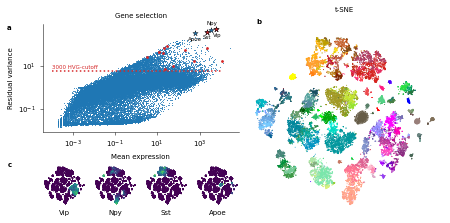

In [7]:
ncols = 2
figheight_in = PAGEWIDTH_IN/ncols
path='figures/main_tasic_hetero_tsne.pdf'
with mpl.rc_context(PAPER_CONTEXT):
    
    nrows_grid = 5
    ncols_grid = 8
    fig = plt.figure(figsize=(PAGEWIDTH_IN,figheight_in))
    ax1 = plt.subplot2grid(shape=(nrows_grid,ncols_grid),   loc=(0, 0),            colspan=4,rowspan=3)
    ax2 = plt.subplot2grid(shape=(nrows_grid,ncols_grid),   loc=(0, 4), colspan=4,rowspan=nrows_grid)
    axes = [plt.subplot2grid(shape=(nrows_grid,ncols_grid), loc=(3, col),          colspan=1,rowspan=2) for col in range(4)]

    data_tag = get_tag(alpha=alpha,theta=theta,clipping=clipping)
    hvg_tag = 'top%u_%s'%(n_hvgs,data_tag)

    
    #ax1
    #gene name offsets
    offsets_x = [0,0,0,0.2]
    offsets_y = [-0.05,-.05 ,1.2, -0.05]
    
    ax1.set_title(fr'Gene selection')

    resvar = adata.var[f'pr_theta{theta}_alpha{alpha:.1f}_var']
    resvar_cutoff = np.sort(resvar)[-n_hvgs]
    ax1.scatter(adata.var['gene_mean'],resvar,linewidth=0,s=POINTSIZE,rasterized=True)
    ax1.scatter(adata.var['gene_mean'][marker_idx],resvar[marker_idx],linewidth=1,s=POINTSIZE_HIGHLIGHT,c='tab:red',rasterized=True)#,label='well-known marker genes')
    starsize = 30
    staredges = 0.4
    ax1.scatter(adata.var['gene_mean'][top4],resvar[top4],s=starsize,marker='*',edgecolors='k',linewidths=staredges,c='tab:blue')

    ax1.scatter(adata.var['gene_mean'][high_resvar_markers],resvar[high_resvar_markers],s=starsize,marker='*',edgecolors='k',linewidths=staredges,c='tab:red')

    for i,marker in enumerate(top4_genes[::-1]):

        m_idx = adata.var['genes'] == marker
        x=adata.var['gene_mean'][m_idx]
        y=adata.var[f'pr_theta{theta}_alpha{alpha:.1f}_var'][m_idx]
        ax1.text(x*(1+offsets_x[i]),y*(0.5+offsets_y[i]),marker,fontdict=dict(fontsize=LEGEND_FONTSIZE),ha='center')
        
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.hlines(resvar_cutoff,0.0001,10000,color='tab:red',linestyle=':')#,label=f'cutoff for {n_hvgs}\nhighly variable genes')
    ax1.text(0.0001,resvar_cutoff*1.4,f'{n_hvgs} HVG-cutoff',fontsize=LEGEND_FONTSIZE,c='tab:red')
    ax1.set_xlabel('Mean expression')
    ax1.set_ylabel('Residual variance')    
    ax1.minorticks_off()
    sns.despine(ax=ax1)
    
    
    tsne_after_HVG_PCA = ads_hvg[-1].obsm['tsne']
    ax2.scatter(*tsne_after_HVG_PCA.T,linewidth=0,s=POINTSIZE,c=colors,rasterized=True)
    ax2.axis('off')
    ax2.set_title('t-SNE',y=1.061)
    ax2.set_aspect('equal')
    
    
    
    
    for marker,ax in zip(top4_genes.values,axes):
        
        m_idx = np.where((adata.var['genes'] == marker).values)[0][0]
        ax.set_xlabel('%s'%(marker))
        marker_expression = np.array(adata.layers['sqrtnorm'][:,m_idx].toarray())
        points = ax.scatter(*tsne_after_HVG_PCA.T,linewidth=0,s=POINTSIZE_SMALL,rasterized=True,c=marker_expression)

        sns.despine(ax=ax,left=True,bottom=True)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        
    plt.tight_layout()
    
    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(SPINEWIDTH)
            
    letters=['a','b','c']
    x_corrections=[0.12,0.35,-0.51]
    y_corrections=[0,0.08,0]
        
    for ax,letter,x_corr,y_corr in zip([ax1,ax2,axes[0]],letters,x_corrections,y_corrections):
        ax.text(LETTER_LOC_X+x_corr,LETTER_LOC_Y+y_corr,letter,transform=ax.transAxes,fontweight='bold')
        
    fig.savefig(path, dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)

### Suppl. Figure 4

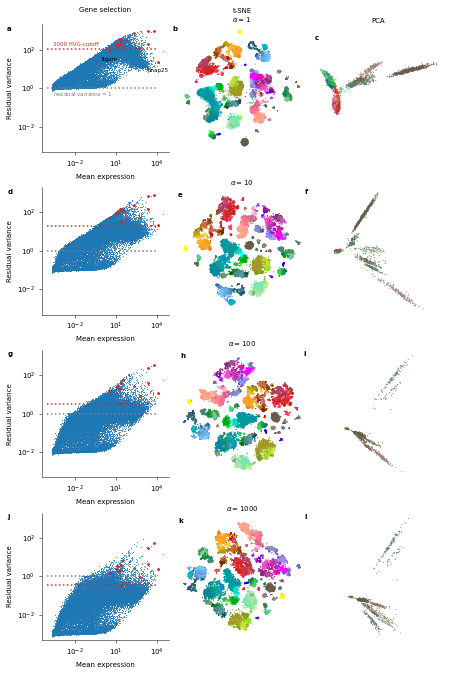

In [8]:
nrows = 4
panelsize_in = PAGEWIDTH_IN/ncols
figheight_in = panelsize_in * 3

path='figures/S_tasic_hetero_param_influence.pdf'
with mpl.rc_context(PAPER_CONTEXT):

    fig,axes = plt.subplots(4,3,figsize=(PAGEWIDTH_IN,figheight_in))

    for row,alpha in enumerate([1,10,100,1000]):

        ax1,ax2,ax3 = axes[row,:]

        data_tag = get_tag(alpha=alpha,theta=theta,clipping=clipping)
        hvg_tag = 'top%u_%s'%(n_hvgs,data_tag)

        

        resvar = adata.var[f'pr_theta{theta}_alpha{alpha:.1f}_var']
        resvar_cutoff = np.sort(resvar)[-n_hvgs]
        ax1.scatter(adata.var['gene_mean'],resvar,linewidth=0,s=POINTSIZE,rasterized=True)
        ax1.scatter(adata.var['gene_mean'][marker_idx],resvar[marker_idx],linewidth=1,s=POINTSIZE_HIGHLIGHT,c='tab:red')
        for marker in markers:

            m_idx = adata.var['genes'] == marker
            x=adata.var['gene_mean'][m_idx]
            y=adata.var[f'pr_theta{theta}_alpha{alpha:.1f}_var'][m_idx]
            if y[0] < resvar_cutoff:
                ax1.text(x,y*0.3,marker,fontdict=dict(fontsize=LEGEND_FONTSIZE),ha='center')
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_ylim([10**-3.3,10**3.3])
        ax1.hlines(1,0.0001,10000,color='tab:gray',linestyle=':')
        ax1.hlines(resvar_cutoff,0.0001,10000,color='tab:red',linestyle=':',)
        if row==0:
            ax1.text(0.00025,resvar_cutoff*1.5,f'{n_hvgs} HVG-cutoff',fontsize=LEGEND_FONTSIZE,c='tab:red')
            ax1.text(0.00025,0.4,r'residual variance$=1$',fontsize=LEGEND_FONTSIZE,c='tab:gray')


        ax1.set_xlabel('Mean expression')
        ax1.set_ylabel('Residual variance')    

        if row==0:
            ax1.set_title('Gene selection',y=1.05)
    

        ax1.minorticks_off()
        for axis in ['bottom','left']:
            ax1.spines[axis].set_linewidth(SPINEWIDTH)


        ad_hvg = alpha2ad_hvg[alpha]
        tsne_after_HVG_PCA = ad_hvg.obsm['tsne']
        ax2.scatter(*tsne_after_HVG_PCA.T,linewidth=0,s=POINTSIZE,c=colors,rasterized=True)
        title_str = fr'$\alpha=${alpha}'
        ax2.set_title(title_str)
        if row==0:
            ax2.set_title(f't-SNE\n{title_str}',y=0.97)
        ax2.set_aspect('equal')


        pca_after_HVG = ad_hvg.obsm['pca'][:,:2]
        ax3.scatter(*pca_after_HVG.T,linewidth=0,s=POINTSIZE,c=colors,rasterized=True)
        if row==0:
            ax3.set_title('PCA',y=1.51)
        ax3.set_aspect('equal')

        sns.despine(ax=ax1)
        sns.despine(ax=ax2,left=True,bottom=True)
        ax2.set_xticks([])
        ax2.set_yticks([])
        sns.despine(ax=ax3,left=True,bottom=True)
        ax3.set_xticks([])
        ax3.set_yticks([])


    plt.tight_layout()
    
    
    letters=['a','b','c',
             'd','e','f',
             'g','h','i',
             'j','k','l']
    x1=0.03
    x2=0.3
    x_corrections=[x1,x2-0.05, 0.3,
                  x1,x2,       0.05,
                  x1,x2+0.02, -0.21,
                  x1,x2,      -0.33,]
    y_corrections=[0,0,0.38,
                  0,0,0,
                  0,0,0,
                  0,0,0,]
        
    for ax,letter,x_corr,y_corr in zip(axes.flatten(),letters,x_corrections,y_corrections):
        ax.text(LETTER_LOC_X+x_corr,LETTER_LOC_Y+y_corr,letter,transform=ax.transAxes,fontweight='bold')
    
    fig.savefig(path, dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)

### Suppl. Figure 5

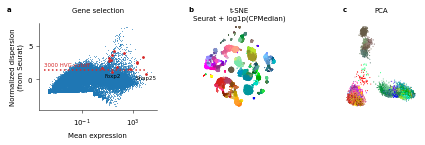

In [9]:
ncols = 3
panelsize_in = PAGEWIDTH_IN/ncols
figheight_in = panelsize_in

path='figures/S_tasic_hetero_scanpy.pdf'
with mpl.rc_context(PAPER_CONTEXT):
    
    hvg_tag = 'top3000_seurat'

    fig,axes = plt.subplots(1,3,figsize=(PAGEWIDTH_IN,figheight_in))


    ax1,ax2,ax3 = axes

    seurat_var = ad_hvg_seurat.uns['hvg_criterion']
    seurat_var_cutoff = np.sort(seurat_var)[-n_hvgs]
    ax1.scatter(adata.var['gene_mean'],seurat_var,linewidth=0,s=POINTSIZE_SMALL,rasterized=True)
    ax1.scatter(adata.var['gene_mean'][marker_idx.values],seurat_var[marker_idx.values],linewidth=1,s=POINTSIZE_HIGHLIGHT,c='tab:red')
    for marker in markers:

        m_idx = adata.var['genes'] == marker
        x=adata.var['gene_mean'][m_idx.values]
        y=seurat_var[m_idx.values]
        if y[0] < seurat_var_cutoff:
            ax1.text(x,y-0.75,marker,fontdict=dict(fontsize=LEGEND_FONTSIZE),ha='center')

    ax1.set_xscale('log')
    ax1.hlines(seurat_var_cutoff,0.0001,10000,color='tab:red',linestyle=':',)
    ax1.text(0.0001,seurat_var_cutoff*1.4,f'{n_hvgs} HVG-cutoff',fontsize=LEGEND_FONTSIZE,c='tab:red')

    ax1.set_xlabel('Mean expression')
    ax1.set_ylabel('Normalized dispersion\n(from Seurat)')    
    ax1.set_title('Gene selection',y=1.05)


    ax1.minorticks_off()
    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(SPINEWIDTH)


    tsne_after_HVG_PCA = ad_hvg_seurat.obsm['tsne']
    ax2.scatter(*tsne_after_HVG_PCA.T,linewidth=0,s=POINTSIZE,c=colors,rasterized=True)
    title_str = 'Seurat + log1p(CPMedian)'
    ax2.set_title(title_str)
    ax2.set_title(f't-SNE\n{title_str}',y=0.97)
    ax2.set_aspect('equal')


    pca_after_HVG = ad_hvg_seurat.obsm['pca'][:,:2]
    ax3.scatter(*pca_after_HVG.T,linewidth=0,s=POINTSIZE,c=colors,rasterized=True)
    ax3.set_title('PCA',y=1.05)
    ax3.set_aspect('equal')

    sns.despine(ax=ax1)
    sns.despine(ax=ax2,left=True,bottom=True)
    ax2.set_xticks([])
    ax2.set_yticks([])
    sns.despine(ax=ax3,left=True,bottom=True)
    ax3.set_xticks([])
    ax3.set_yticks([])    
    
    letters=['a','b','c']
    x_corrections=[0.03,0.15, 0.3]
    y_corrections=[0.18,0.18,0.18]
        
    for ax,letter,x_corr,y_corr in zip(axes.flatten(),letters,x_corrections,y_corrections):
        ax.text(LETTER_LOC_X+x_corr,LETTER_LOC_Y+y_corr,letter,transform=ax.transAxes,fontweight='bold')
    
    plt.tight_layout()

    fig.savefig(path, dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)

### Suppl. Figure 6

tcmalloc: large alloc 2976530432 bytes == 0x8b7024000 @ 
tcmalloc: large alloc 2976530432 bytes == 0x988ee0000 @ 
tcmalloc: large alloc 2976530432 bytes == 0xa3a584000 @ 
tcmalloc: large alloc 2976530432 bytes == 0xaebc28000 @ 


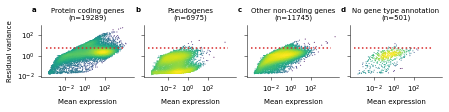

In [10]:
ncols = 4
panelsize_in = PAGEWIDTH_IN/ncols
figheight_in = panelsize_in


alpha = 50
data_tag = get_tag(alpha=alpha,theta=theta,clipping=clipping)
hvg_tag = f'top{n_hvgs}_{data_tag}'


def plot_fig2a_panel(genetype,ax,title,kde=True):

    resvar = adata.var[f'pr_theta{theta}_alpha{alpha:.1f}_var']
    resvar_cutoff = np.sort(resvar)[-n_hvgs]
    genetype_idx = adata.var['coarse_types']==genetype
    
    x=adata.var['gene_mean'][genetype_idx]
    y=resvar[genetype_idx]
    if kde:
        logdensity = compute_kde(x,y,xscale='log',yscale='log')
    else:
        logdensity=None
    ax.scatter(x,y,s=POINTSIZE,linewidth=0,c=logdensity,rasterized=True)
    ax.set_title(f'{title}\n(n={sum(genetype_idx)})')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.hlines(resvar_cutoff,0.0001,10000,color='tab:red',linestyle=':')

    ax.set_xlabel('Mean expression')
    ax.set_ylabel('Residual variance') 
    plt.yticks([10**-2,10**0,10**2])
    plt.xticks([10**-2,10**0,10**2])
    ax.minorticks_off()


    sns.despine(ax=ax)
    
path='figures/S_tasic_hetero_pseudogenes.pdf'
with mpl.rc_context(PAPER_CONTEXT):

    fig,axes = plt.subplots(1,4,figsize=(PAGEWIDTH_IN,figheight_in),sharey=True,sharex=True)
    
    plot_fig2a_panel('protein_coding',axes[0],'Protein coding genes')
    
    plot_fig2a_panel('pseudogene',axes[1],'Pseudogenes')
    axes[1].set_ylabel('')
    
    plot_fig2a_panel('other',axes[2],'Other non-coding genes')
    axes[2].set_ylabel('')
    
    plot_fig2a_panel('missing',axes[3],'No gene type annotation')
    axes[3].set_ylabel('')
    
    plt.tight_layout()
    
    for ax in axes:
        for axis in ['bottom','left']:
            ax.spines[axis].set_linewidth(SPINEWIDTH)
            
    letters=['a','b','c','d']   
    for ax,letter, in zip(axes,letters):
        ax.text(LETTER_LOC_X+0.2,LETTER_LOC_Y+0.31,letter,transform=ax.transAxes,fontweight='bold')

    fig.savefig(path, dpi=300, format=None, bbox_inches = 'tight', pad_inches = 0)

### Additional Figures

#### Influence of re-computing residuals after HVG selection

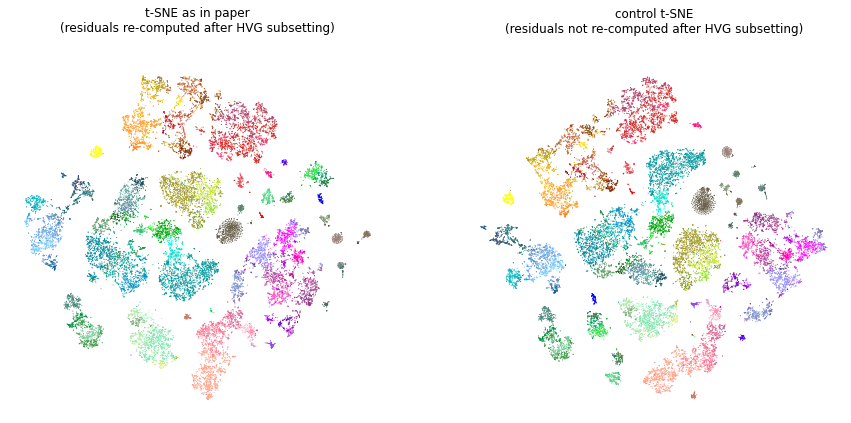

In [11]:
_,(ax2,ax3) = plt.subplots(1,2,figsize=(10*1.5,5*1.5))
POINSIZE=10

tsne_after_HVG_PCA = ads_hvg[-1].obsm['tsne']
ax2.scatter(*tsne_after_HVG_PCA.T,linewidth=0,s=POINTSIZE,c=colors,rasterized=True)
ax2.axis('off')
ax2.set_title('t-SNE as in paper\n(residuals re-computed after HVG subsetting)',y=1.061)
ax2.set_aspect('equal')

tsne_after_HVG_PCA = ads_hvg[-1].obsm['tsne_hvg_control']
ax3.scatter(*tsne_after_HVG_PCA.T,linewidth=0,s=POINTSIZE,c=colors,rasterized=True)
ax3.axis('off')
ax3.set_title('control t-SNE\n(residuals not re-computed after HVG subsetting)',y=1.061)
ax3.set_aspect('equal')

#### Expression patterns of the top 20 selected scanpy genes

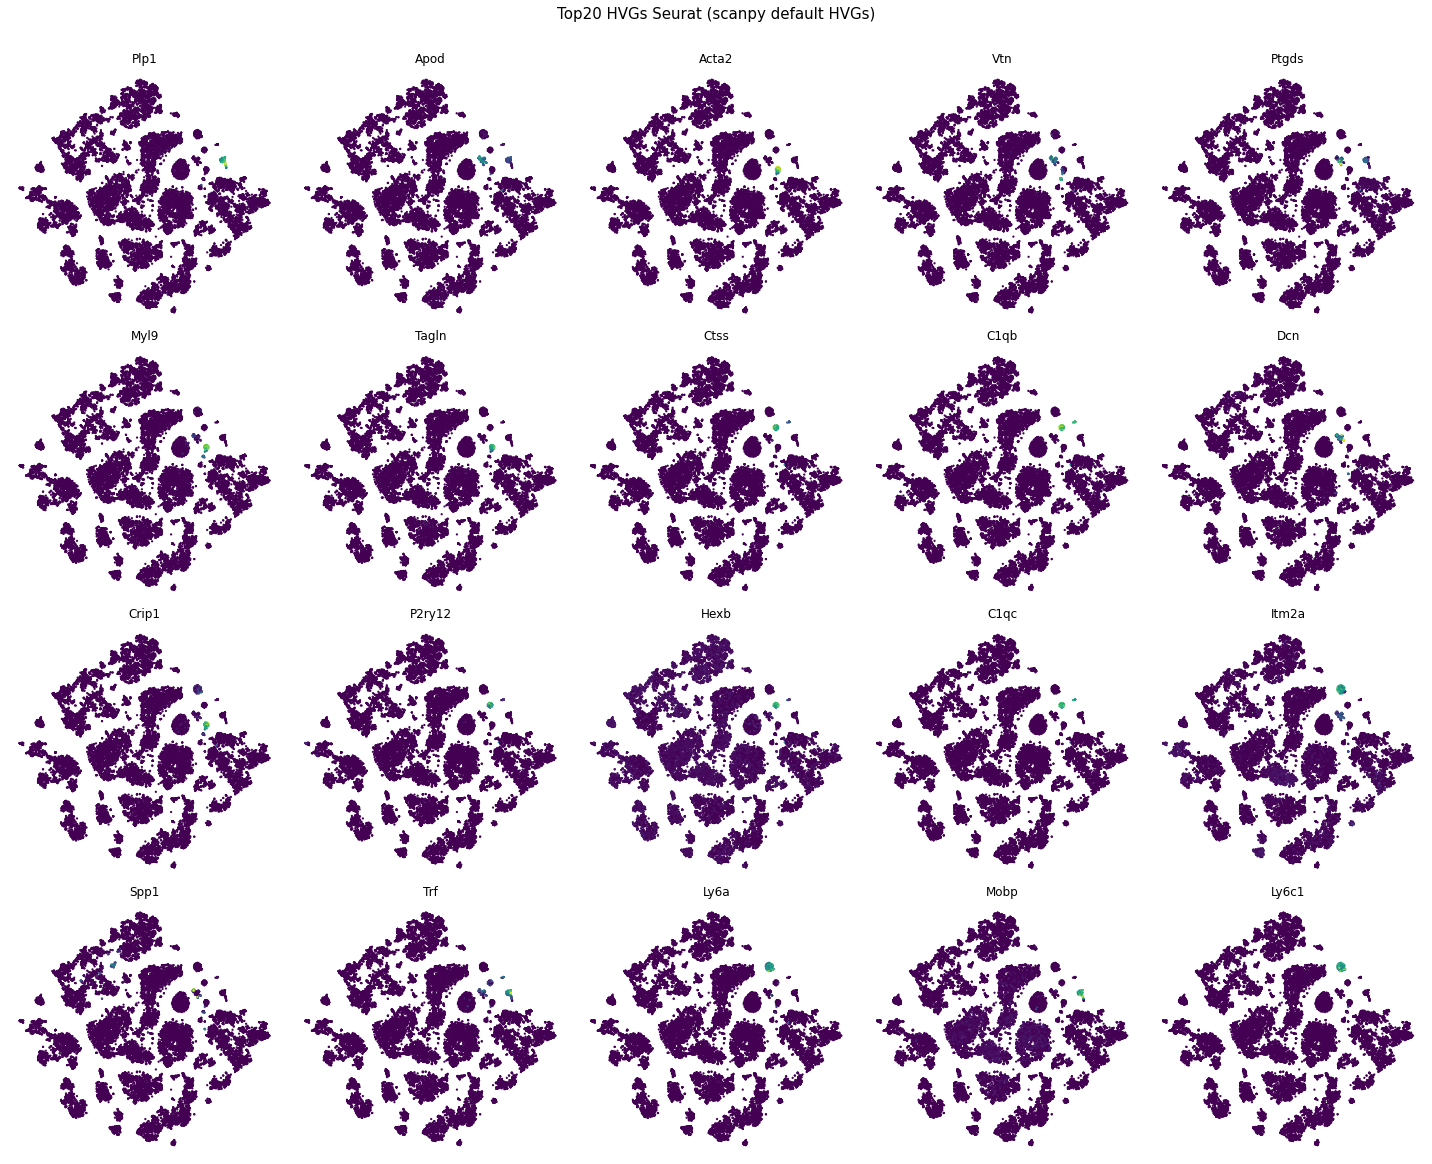

In [12]:
seurat_var_sortidx = np.argsort(-seurat_var)
seurat_top20_idx = seurat_var_sortidx[:20]
top20_genes_seurat = adata.var['genes'][seurat_top20_idx] 

fig,axes = plt.subplots(4,5,figsize=(25*0.8,20*0.8))
for marker,ax in zip(top20_genes_seurat.values,axes.flatten()):

    m_idx = np.where((adata.var['genes'] == marker).values)[0][0]
    ax.set_title('%s'%(marker))
    marker_expression = np.array(adata.layers['sqrtnorm'][:,m_idx].toarray())
    points = ax.scatter(*tsne_after_HVG_PCA.T,linewidth=0,s=5,rasterized=True,c=marker_expression)
    # plt.colorbar(points, ax=ax,shrink=0.4)

    # ax.axis('off')
    sns.despine(ax=ax,left=True,bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
plt.suptitle('Top20 HVGs Seurat (scanpy default HVGs)',fontsize=15,y=1.01)
plt.tight_layout()

#### Expression patterns of the top 20 selected compound Pearson residuals genes

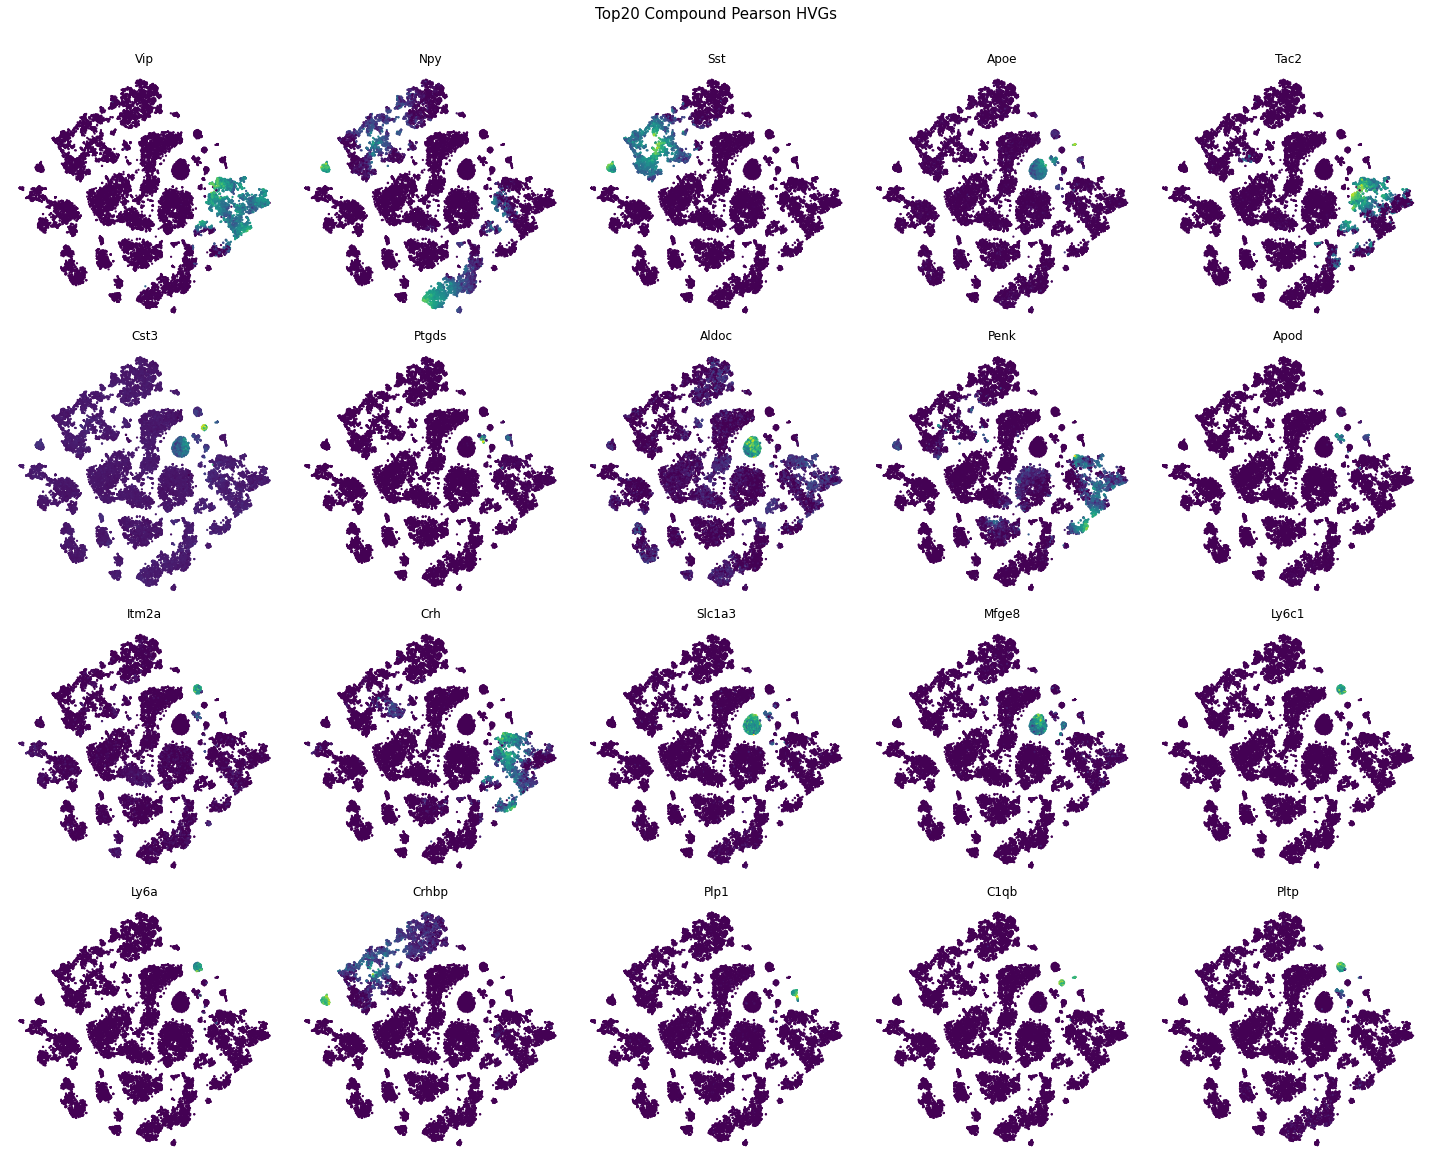

In [13]:
resvar_sortidx = np.argsort(-adata.var[f'pr_theta{theta}_alpha{alpha:.1f}_var'])
resvar_top20_idx = resvar_sortidx[:20]
top20_genes_resvar = adata.var['genes'][resvar_top20_idx] 

fig,axes = plt.subplots(4,5,figsize=(25*0.8,20*0.8))
for marker,ax in zip(top20_genes_resvar.values,axes.flatten()):

    m_idx = np.where((adata.var['genes'] == marker).values)[0][0]
    ax.set_title('%s'%(marker))
    marker_expression = np.array(adata.layers['sqrtnorm'][:,m_idx].toarray())
    points = ax.scatter(*tsne_after_HVG_PCA.T,linewidth=0,s=5,rasterized=True,c=marker_expression)
    # plt.colorbar(points, ax=ax,shrink=0.4)

    # ax.axis('off')
    sns.despine(ax=ax,left=True,bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
plt.suptitle('Top20 Compound Pearson HVGs',fontsize=15,y=1.01)
plt.tight_layout()